In [1]:
import os
import sys

from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan,atan2,copysign
import numpy as np

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
import scipy
from scipy.stats import norm
import random
import time
import timeit
import math
import localization as lx
import gzip

import util.npose_util as nu
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree

import tensorflow as tf
import joblib
from sklearn.manifold import MDS
import argparse
from functools import partial
from itertools import starmap,repeat,permutations

from pymol import cmd, stored, selector

import GenerateEndpoints as ge
import HelixFit as hf
import FitTransform as ft

import seaborn as sns
import util.RotationMethods as rm

#reference helix for propogation
zero_ih = nu.npose_from_file('util/zero_ih.pdb')
tt = zero_ih.reshape(int(len(zero_ih)/5),5,4)
stub = tt[7:10].reshape(15,4)

np.set_printoptions(precision=2)

In [2]:
#load distance maps
def load_distance_map(name, dm_file='data/Fits_4H_dm_phi.npz'):
    rr = np.load(dm_file, allow_pickle=True)
    X_train, y_train , featNames = [rr[f] for f in rr.files]
    
    
    return X_train[y_train==name][:,:-4]


In [3]:
dm_file = 'data/Fits_4H_dm_phi.npz'
rr = np.load(dm_file, allow_pickle=True)
X_train, y_train , featNames = [rr[f] for f in rr.files]

In [4]:
model_direc = 'data/4H_dataset/models/'
# cmd.load(f'{model_direc}{y_train[0]}.pdb')

# cmd.save(f'output/test.pdb')

In [5]:
#endpoints for data set 
Fits4H_file = 'data/Fits_4H.csv'
dfRead = pd.read_csv(Fits4H_file)
df1 = ft.prepData_Str(dfRead,rmsd_filter=100)
df2 = ft.EndPoint(df1)
ep = df2.to_numpy()[:,:24].astype(float).reshape((-1,8,3))
X = ep

In [6]:
def bi(helices_to_keep, num_helices=4, intraHelixDist=True):
    """Get index values for parts of the distance map"""
    
    #prep indices for distance map
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    
    helix_used = np.array(helices_to_keep,dtype=int)
    
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    tot_ind = []
    
    if intraHelixDist:
        #get indices of distance map that correspond to each helix, overlap is distances between specified endpoints
        for x in helix_used:
            new_ind = np.intersect1d(mat_ind[h_ep[x]], mat_ind.T[h_ep[x]])
            tot_ind.extend(new_ind)
    
    
    for x in permutations(helix_used,2):
        new_ind = np.intersect1d(mat_ind[h_ep[x[0]]], mat_ind.T[h_ep[x[1]]])
        tot_ind.extend(new_ind)
    
    return np.intersect1d(tot_ind,mat_ind[iu1])



def bi_single(ep_index,num_helices=4, singlePoint=-1):
    
    #prep indices for distance map
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    il1 = np.tril_indices(num_ep, 1)
    tot_ind = []
    
    if singlePoint == -1:
        for x in permutations(ep_index,2):
            new_ind = np.intersect1d(mat_ind[x[0]], mat_ind.T[x[1]])
            tot_ind.extend(new_ind)
    else: 
        for x in (ep_index):
            new_ind = np.intersect1d(mat_ind[x], mat_ind.T[singlePoint])
            tot_ind.extend(new_ind)
    
    upperInd = np.intersect1d(tot_ind,mat_ind[iu1])
    lowerInd = np.intersect1d(tot_ind,mat_ind[il1])
    
    if len(upperInd)>len(lowerInd):
        return upperInd
    else:
        return lowerInd
    
def index_helix_ep(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    hi = np.array(helices_desired,dtype=int)
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    #alternate example for indexing batch of X 
    #X.reshape((X.shape[0],-1))[:,indexarray]
    
    #select desired endpoints from  batch of endpoints
    return X[np.ix_(np.array(range(ep_in.shape[0])),h_ep[hi].flatten(), np.array(range(ep_in.shape[2])))]
    
def get_midpoint(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    
    ind_ep = index_helix_ep(ep_in, helices_desired=helices_desired, num_helices=4)
    
    #calculate midpoint
    midpoint = ind_ep.sum(axis=1)/np.repeat(ind_ep.shape[1], ind_ep.shape[2])
    
    return midpoint
#method to view points in pymol  
# hf.HelicalProtein.makePointPDB(list([mp[100]]),f'midpoint.pdb',outDirec='output/')
# hf.HelicalProtein.makePointPDB(X[100] ,f'buttend.pdb',outDirec='output/')    

def angle_3sides(s1,s2,s3):
    """Returns angle across from side 3"""
    
    s1sq = np.square(s1)
    s2sq = np.square(s2)
    s3sq = np.square(s3)
    
    return np.arccos((-s3sq+s2sq+s1sq)/(2*s1*s2))

def plane_normVec(p1,p2,p3):
    """Normal vector to plane, P2 is central"""
    
    v1 = p1-p2
    v2 = p3-p2
    nv = np.cross(v2,v1)
    
    return nv/np.linalg.norm(nv)
    
    
    
    

In [7]:
#distance map and midpoint calculation of dataset

#distance map of ep dataset
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dX = np.expand_dims(X,axis=1) - np.expand_dims(X,axis=2)
dist = np.sqrt(np.sum(dX**2, 3))  #+ 1e-6) #this dataset is good 

mp_01 = get_midpoint(X,helices_desired=[0,1])
mp_23 = get_midpoint(X,helices_desired=[2,3])
# d= np.linalg.norm(mp_02-mp_01,axis=1)
# sns.histplot(d)

#mp distance map
ep_mp = np.hstack((X.reshape((-1,24)),mp_01,mp_23)).reshape(-1,10,3) #helix12mp=8  helix34mp=9
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dep_mp = np.expand_dims(ep_mp,axis=1) - np.expand_dims(ep_mp,axis=2)
dist_mp = np.sqrt(np.sum(dep_mp**2, 3))  #+ 1e-6) #this dataset is good 

In [57]:
d = dist_mp.reshape((dist_mp.shape[0],-1))
ds = np.square(d)
d0 = d[0]
ds0 = ds[0]

In [ ]:
#apply 3 base points to z plane for simplicity
#in my case lets start with point indices 1,2,3

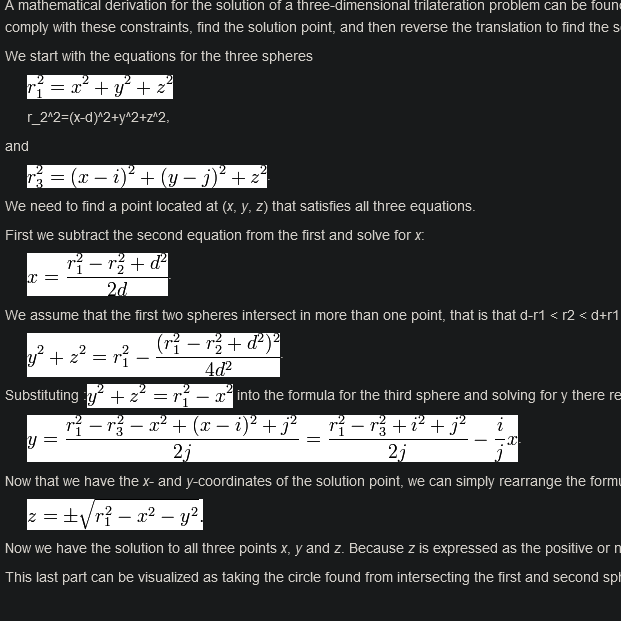

In [317]:
#http://wiki.gis.com/wiki/index.php/Trilateration

r1 = d0[14]
r2 = d0[24]
r3 = d0[34]


dvar = d0[12]
p1 = np.array([0,0,0])
p2 = np.array([dvar,0,0])


ang3 = angle_3sides(dvar,d0[13],d0[23])
v13 = np.array([np.cos(ang3),np.sin(ang3),0])
p3 = d0[13]*v13

ivar = p3[0]
jvar = p3[1]

x = (r1**2-r2**2+dvar**2)/(2*dvar)
y = (r1**2-r3**2+ivar**2+jvar**2)/(2*jvar)-(ivar/jvar)*x
z = np.sqrt(r1**2-x**2-y**2) # z can be plus or mins, important for midpoint comparison



print(p1,p2,p3)
print(r1,r2,r3)
print(dvar,ivar,jvar)

[0 0 0] [10.4  0.   0. ] [23.18 23.99  0.  ]
27.137702968393526 23.31156321223995 9.980551257639517
10.397502711828345 23.175041623851897 23.989308021527517


In [488]:
def xform_to_z_plane(mobile, index_mobile=[0,1,2]):

    mobile_stub = get_stubs_from_points(mobile, index=index_mobile)
    mobile_stub_inv = np.linalg.inv(mobile_stub)
    
    z_plane_ref = np.repeat(np.array([[[-1,-1,0],[-1,0,0],[0,0,0]]]), mobile.shape[0],axis=0)
    print(z_plane_ref.shape)

    ref_stub = get_stubs_from_points(z_plane_ref, index=[0,1,2])

    xform = ref_stub @ mobile_stub_inv

    return xform

In [497]:
def get_stubs_from_points(ep_in,index=[0,1,2]):
#def get_stubs_from_n_ca_c(n, ca, c):
    """Modified from Brian's npose code  get_stubs_from_n_ca_c, index references 3 points, to define plane.
    """
    e1 = ep_in[:,index[1]]-ep_in[:,index[0]]
    e1 = np.divide( e1, np.linalg.norm(e1, axis=1)[..., None] )

    e3 = np.cross( e1, ep_in[:,index[2]]-ep_in[:,index[0]], axis=1 )
    e3 = np.divide( e3, np.linalg.norm(e3, axis=1)[..., None] )

    e2 = np.cross( e3, e1, axis=1 )

    stub = np.zeros((len(ep_in), 4, 4))
    stub[...,:3,0] = e1
    stub[...,:3,1] = e2
    stub[...,:3,2] = e3
    stub[...,:3,3] = ep_in[:,index[1]]
    stub[...,3,3] = 1.0

    return stub

def xform_npose_2batch(xform, npose):
    return np.matmul(np.repeat(xform[:,np.newaxis,...],npose.shape[1],axis=1),npose[...,None]).squeeze(-1)

In [530]:
def xform_to_z_plane(mobile, index_mobile=[0,1,2]):

    mobile_stub = get_stubs_from_points(mobile, index=index_mobile)
    mobile_stub_inv = np.linalg.inv(mobile_stub)
    
    z_plane_ref = np.repeat(np.array([[[0,0,0],[1,0,0],[1,1,0]]]), mobile.shape[0],axis=0)

    ref_stub = get_stubs_from_points(z_plane_ref, index=[0,1,2])

    xform = ref_stub @ mobile_stub_inv

    return xform

In [598]:
zplanexform = xform_to_z_plane(ep_mp,index_mobile=[1,2,3])
npose = np.concatenate((ep_mp, np.ones((ep_mp.shape[0],ep_mp.shape[1],1))),axis=2)
print(npose.shape)
rot1 = nu.xform_npose(zplanexform[0], npose[0])


rot = xform_npose_2batch(zplanexform,npose)

#reflect new points across the z axis to positive if negative to match just choosing positive solutions
rot[:,:,0] = rot[:,:,0]-np.expand_dims(rot[:,1,0],axis=1)
# rot[:,:,0] = 100

(27877, 10, 4)


In [599]:
a=rot[:,:,0]-np.expand_dims(rot[:,0,0],axis=1)

In [600]:
rot.shape

(27877, 10, 4)

In [601]:
a.shape

(27877, 10)

In [602]:
rot[:,:,0].shape

(27877, 10)

In [603]:
rot[0][1:5]

array([[ 0.00e+00, -1.78e-15, -1.78e-15,  1.00e+00],
       [ 1.04e+01,  0.00e+00,  0.00e+00,  1.00e+00],
       [ 2.32e+01,  2.40e+01,  0.00e+00,  1.00e+00],
       [ 1.45e+01,  2.25e+01,  4.66e+00,  1.00e+00]])

In [604]:
x,y,z

(14.481073676585785, 22.472803325963532, 4.661173483856981)

In [674]:
dmap = dist_mp.reshape((dist_mp.shape[0],-1))
dindex=[14,24,34,12,23,13]
    
r1 = dmap[:,dindex[0]].reshape((-1,1))
r2 = dmap[:,dindex[1]].reshape((-1,1))
r3 = dmap[:,dindex[2]].reshape((-1,1))

dvar = dmap[:,dindex[3]].reshape(-1,1)
p1 = np.repeat(np.array([[0,0,0]]),dmap.shape[0],axis=0)
p2 = np.zeros_like(p1)
p2[:,0] = dvar.flatten()


def array_map(s1,s2,s3):
    return np.array(list(map(angle_3sides, s1,s2,s3)))

ang3 = array_map(dvar, dmap[:, dindex[5]], dmap[:,dindex[4]]).reshape((-1,1))
v13 = np.concatenate([np.cos(ang3),np.sin(ang3),np.zeros_like(ang3)],axis=1)
p3 = dmap[:,dindex[5]].reshape((-1,1))*v13

ivar = p3[:,0].reshape((-1,1))
jvar = p3[:,1].reshape((-1,1))

x = (r1**2-r2**2+dvar**2)/(2*dvar)
y = (r1**2-r3**2+ivar**2+jvar**2)/(2*jvar)-(ivar/jvar)*x
z = np.sqrt(r1**2-x**2-y**2) # z can be plus or mins, important for midpoint comparison

newpoint = np.concatenate((x,y,z),axis=1)

In [676]:
newpoint

array([[14.48, 22.47,  4.66],
       [16.02, 20.75,  6.31],
       [20.45, 17.22,  8.92],
       ...,
       [ 6.49, 18.57,  6.67],
       [14.66, 16.32,  9.37],
       [19.7 , 17.25,  7.48]])

In [ ]:
def get_final_tetrahedron(dmap, dindex=[14,24,34]):
    
    r1 = dmap[:,dindex[0]]
    r2 = dmap[:,dindex[1]]
    r3 = dmap[:,dindex[2]]
    

In [397]:
#http://wiki.gis.com/wiki/index.php/Trilateration

r1 = d0[14]
r2 = d0[24]
r3 = d0[34]


dvar = d0[12]
p1 = np.array([0,0,0])
p2 = np.array([dvar,0,0])


ang3 = angle_3sides(dvar,d0[13],d0[23])
v13 = np.array([np.cos(ang3),np.sin(ang3),0])
p3 = d0[13]*v13

ivar = p3[0]
jvar = p3[1]

x = (r1**2-r2**2+dvar**2)/(2*dvar)
y = (r1**2-r3**2+ivar**2+jvar**2)/(2*jvar)-(ivar/jvar)*x
z = np.sqrt(r1**2-x**2-y**2) # z can be plus or mins, important for midpoint comparison



print(p1,p2,p3)
print(r1,r2,r3)
print(dvar,ivar,jvar)

[0 0 0] [10.4  0.   0. ] [23.18 23.99  0.  ]
27.137702968393526 23.31156321223995 9.980551257639517
10.397502711828345 23.175041623851897 23.989308021527517


In [398]:
x,y,z

(14.481073676585785, 22.472803325963532, 4.661173483856981)

In [365]:
rot[0][4]

array([ 19.78, -12.  ,  -4.66,   1.  ])

In [366]:
x-5

9.481073676585785

In [293]:
#method to view points in pymol  
hf.HelicalProtein.makePointPDB(list(ep_mp[0][1:5]),f'ep_midpoint.pdb',outDirec='output/')
#hf.HelicalProtein.makePointPDB(dist_mp ,f'buttend.pdb',outDirec='output/')    


1

In [14]:
ep_mp[0]

array([[ -0.76,   2.91,   0.6 ],
       [  8.35,  12.29,  10.85],
       [ 12.17,   7.2 ,   2.62],
       [ -4.71,   1.7 , -17.96],
       [ -5.42,   9.97, -12.42],
       [ 12.66,  19.39,   0.54],
       [  5.2 ,  18.8 ,   5.23],
       [ -8.8 ,  10.12,  -2.31],
       [  3.76,   6.02,  -0.97],
       [  0.91,  14.57,  -2.24]])

In [9]:
dist_mp.shape

(27877, 10, 10)

In [10]:
d = dist_mp.reshape((dist_mp.shape[0],-1))
ds = np.square(dist_mp).reshape((dist_mp.shape[0],-1))

In [98]:
ep_mp.shape

(27877, 10, 3)

In [278]:
a123 = angle_3sides(d[0][12],d[0][23],d[0][13])
print(a123)

2.0602096100579583


In [20]:
d[0][14]

27.137702968393526

In [23]:
a124 *( 180/np.pi )

100.0887619962719

In [21]:
a124 = angle_3sides(d[0][12],d[0][24],d[0][14])
a234 = angle_3sides(d[0][23],d[0][24],d[0][34])

print(a234)

0.3675716185435968


In [219]:
v23 = rm.normalize(ep_mp[0][3] - ep_mp[0][2])
v21 = rm.normalize(ep_mp[0][1] - ep_mp[0][2])
origin = ep_mp[0][2]

In [223]:
origin

array([12.17,  7.2 ,  2.62])

In [220]:
print(v21)

[ 0.37 -0.49 -0.79]


[-0.37  0.49  0.79]


In [31]:
ti = 0

a124 = angle_3sides(d[ti][12],d[ti][24],d[ti][14])
a234 = angle_3sides(d[ti][23],d[ti][24],d[ti][34])

v23 = rm.normalize(ep_mp[ti][3] - ep_mp[ti][2])
v21 = rm.normalize(ep_mp[ti][1] - ep_mp[ti][2])
origin = ep_mp[ti][2]

rot_point = v21*d[0][24]
print(rot_point)

[-8.56 11.41 18.44]


In [32]:
hf.HelicalProtein.makePointPDB(list(ep_mp[0][1:5]),f'ep_midpoint.pdb',outDirec='output/')

1

In [43]:
#https://math.stackexchange.com/questions/2465365/irregular-tetrahedron-problem

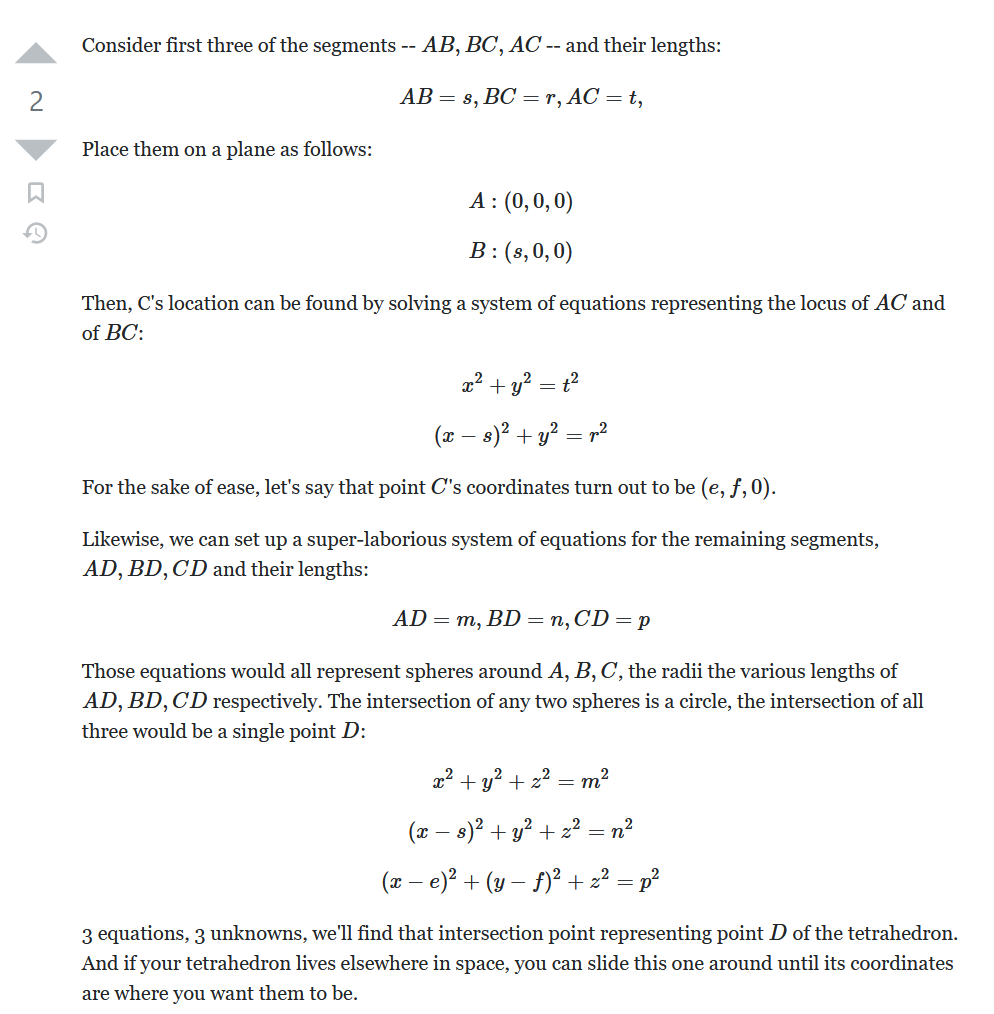

https://www.eng.uc.edu/~beaucag/Classes/Properties/OptionalProjects/CoordinateTransformationCode/Rotate%20about%20an%20arbitrary%20axis%20(3%20dimensions).html

In [39]:
axisRot1 = v23
ang1 = a124

aRot1=np.hstack((axisRot1,[1]))

xform1 = nu.xform_from_axis_angle_rad(aRot1,ang1)

npose = np.hstack((rot_point,[1]))
print(ang1,axisRot1)




out=nu.xform_npose(xform1, np.expand_dims(npose,axis=0) )



intermed_point = out[0]

axisRot2 = v21
ang2 = a234
aRot2=np.hstack((axisRot2,[1]))


print(ang2,axisRot2)



xform2 = nu.xform_from_axis_angle_rad(aRot2,np.pi/2-ang2)


out1=nu.xform_npose(xform2, np.expand_dims(intermed_point,axis=0) )


1.746878441079917 [-0.62 -0.2  -0.76]
0.3675716185435968 [-0.37  0.49  0.79]


In [ ]:
#http://wiki.gis.com/wiki/index.php/Trilateration



In [40]:
hf.HelicalProtein.makePointPDB([list(out1[0][:3]+origin)],f'out.pdb',outDirec='output/')

1

In [41]:
0.3675716185435968*(180/np.pi)

21.060302411340725

In [785]:
print(out1[:3]*d[ti][24]+origin)

[-9.83 -0.21 -2.78]


In [786]:
print(ep_mp[ti][4])

[ 12.3    1.85 -12.29]


In [710]:
np.sqrt(np.sum(np.square(origin-ep_mp[0][4])))

16.45095092429474

In [711]:
print(ep_mp[0][4])

[ -5.42   9.97 -12.42]


In [706]:
d[0][24]

23.31156321223995

In [192]:
origin

array([12.17,  7.2 ,  2.62])

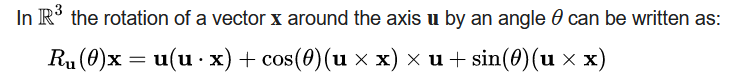


In [135]:
#axis angle

u = v1
x = pnew

pfinal = u*np.dot(u,x) + np.cos(-a124)*np.cross(np.cross(u,x),u) + np.sin(-a124)*np.cross(u,x)



In [136]:
pfinal*d[0][24]

array([ -8.95, -21.48,  -1.4 ])

In [137]:
ep_mp[0][9]

array([ 0.91, 14.57, -2.24])

In [138]:
ep_mp[0][4]

array([ -5.42,   9.97, -12.42])

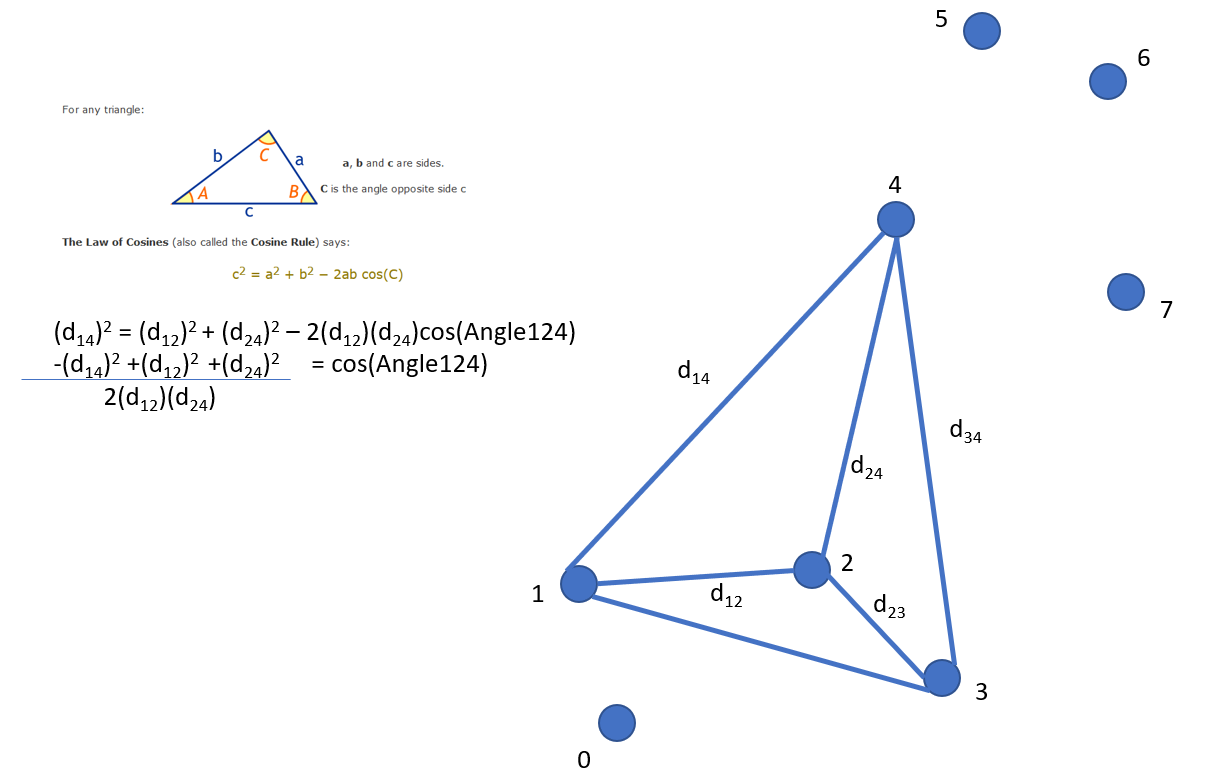

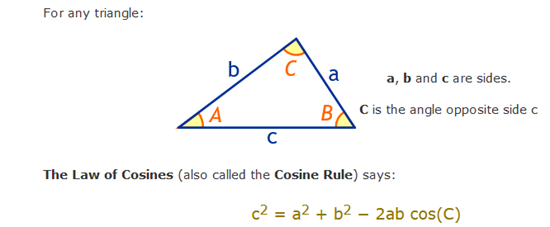

In [86]:
ang124 = np.arccos( (-ds[0][14]+ds[0][12]+ds[0][24])/(2*d[0][12]*d[0][24]))   

In [87]:
ang124

1.746878441079917

In [56]:
mpd_34  = dist_mp.reshape((dist_mp.shape[0],-1))[:,bi_single([4,5,6,7],singlePoint=9,num_helices=5)]

In [58]:
mpd_34.shape

(27877, 4)

In [59]:
dd_34  = dist_mp.reshape((dist_mp.shape[0],-1))[:,bi([2,3],num_helices=5)]

In [62]:
dh = dd_34[:,[1,-2]]/2


In [63]:
dh

array([[11.21, 11.78],
       [12.86,  9.21],
       [10.63, 12.1 ],
       ...,
       [12.07, 11.51],
       [11.36, 11.53],
       [12.15, 11.67]])

In [69]:
np.mean(mpd_34.reshape((-1,2,2)),axis=2)-dh

array([[ 1.72, -1.64],
       [-0.71,  0.83],
       [ 1.88, -1.68],
       ...,
       [ 1.66, -1.19],
       [ 2.29, -2.03],
       [ 1.59, -1.34]])

In [48]:
bi_single([4,5,6,7],singlePoint=9,num_helices=5)

array([49, 59, 69, 79])

In [43]:
mpd_34.reshape((-1,4))

array([[12.84, 13.  ,  9.6 , 10.69]])

In [45]:
dd_34

array([24.16, 22.41, 10.67,  8.83, 23.55, 18.12])

In [46]:
bi([2,3],num_helices=5)

array([45, 46, 47, 56, 57, 67])

In [47]:
print(mat_ind)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


In [37]:
hi01 = buttress_index([0,1], num_helices=4)
hi23 = buttress_index([2,3], num_helices=4)

In [47]:
hi02 = buttress_index([0,2], num_helices=4)
hi03 = buttress_index([0,3], num_helices=4)
hi12 = buttress_index([1,2], num_helices=4)
hi13 = buttress_index([1,3], num_helices=4)

In [14]:
num_helices=5
num_ep = num_helices*2
mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
print(mat_ind)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


In [179]:
bi_single([4,5,6,7],singlePoint=0)

array([32, 40, 48, 56])

In [180]:

mat_ind = []
for x in range(4):
    mat_ind.append(bi_single([4,5,6,7],singlePoint=x,num_helices=5))

In [181]:
mat_ind

[array([40, 50, 60, 70]),
 array([41, 51, 61, 71]),
 array([42, 52, 62, 72]),
 array([43, 53, 63, 73])]

In [187]:
for x in mat_ind:
    print(dt[x])

[15.53 21.25 17.59 11.19]
[27.14 13.24  9.16 21.72]
[23.31 12.38 13.78 21.74]
[ 9.98 30.93 30.47 18.24]


In [121]:
# bi_m0 = buttress_index_single([9, 4,5,6,7],num_helices=5)
# bi_m1 = buttress_index_single([8, 0,1,2,3],num_helices=5)
bi_m8 = buttress_index_single([4,5,6,7],num_helices=5, singlePoint=8)
bi_m9 = buttress_index_single([0,1,2,3],num_helices=5, singlePoint=9)
dt = dist_mp[0].flatten()

In [162]:
bi_m8

array([48, 58, 68, 78])

In [184]:
dt[bi_m8]

array([15.2 , 16.13, 14.28, 13.28])

In [41]:
np.mean(dist[0].flatten()[hi01])

20.055350373172203

In [40]:
np.meandist[0].flatten()[hi23]

array([24.16, 22.41, 10.67,  8.83, 23.55, 18.12])

In [42]:
d[0]

9.098917339600844

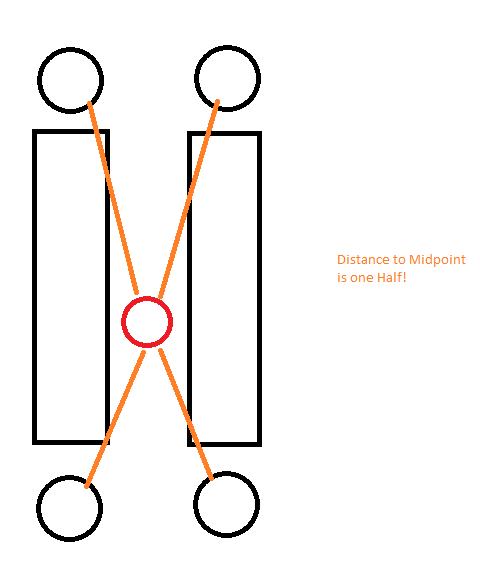

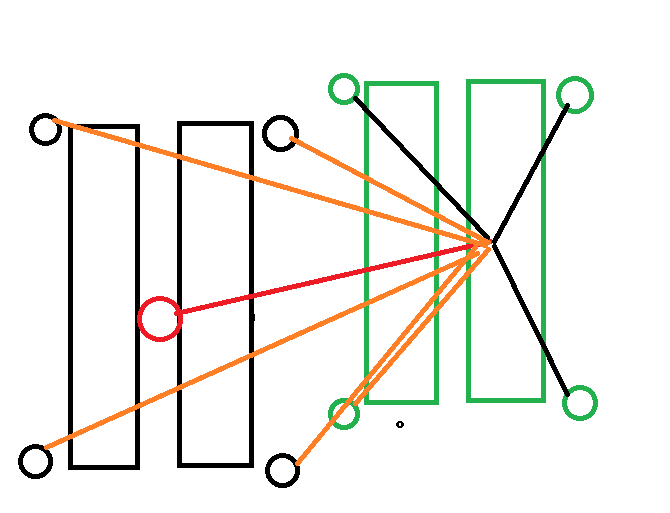

In [9]:
#input will be 4 endpoints (2 helices to be added on to)
#get midpoints of helices, and from that midpoint create a vector to the desired direction

<AxesSubplot:ylabel='Count'>

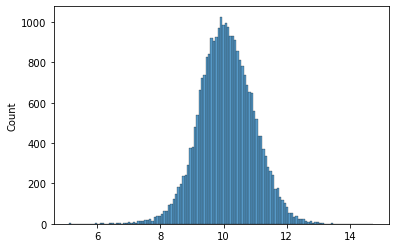

In [34]:
mp_01 = get_midpoint(X,helices_desired=[0,1])
mp_02 = get_midpoint(X,helices_desired=[2,3])
d= np.linalg.norm(mp_02-mp_01,axis=1)
sns.histplot(d)

In [ ]:
def maskLoss_directional():
    
    

@tf.function
def maskLoss(y_actual, y_pred,mask):
    custom_loss_val = tf.multiply(mask,tf.square(y_actual-y_pred))
    return custom_loss_val


@tf.function
def directionalLoss(y_actual, y_pred,mask,mid_dist):
    
    
    dhalf_actual = tf.multiply(y_actual,0.5) #distances to midpoints ('masked of course')
    dhalf_pred = tf.multiply(y_pred,0.5) #distances to midpoints ('masked of course')
    
    
    custom_loss_val = tf.multiply(mask,tf.square(y_actual-y_pred))
    return custom_loss_val
    

In [10]:
def checkLoss2(testArray,refArray,mask):

    return np.sum(np.square(refArray-testArray)*mask,axis=1)

@tf.function
def maskLoss(y_actual, y_pred,mask):
    custom_loss_val = tf.multiply(mask,tf.square(y_actual-y_pred))
    return custom_loss_val

def buttLoss(recon,mask,refMap,input_z=None,rate=0.05,batch_size=32,cycles=100):

    recon.batch_size = batch_size
    vecDes = recon.mm.transform(np.repeat(refMap.reshape(1,-1) , batch_size, axis=0))
    
    mask =  np.repeat(np.array(mask).reshape(1,-1) , batch_size,axis=0)

    v=tf.convert_to_tensor(vecDes)
    m=tf.convert_to_tensor(mask)
    m2=tf.cast(m, tf.float32)
    v=tf.cast(v,tf.float32)

    if input_z is None:
        input_z = tf.random.uniform(shape=(batch_size,recon.z_size), minval=-1, maxval=1)


    rate = tf.Variable(0.1)
    input_z_var = tf.Variable(input_z)
    g_o = recon.g(input_z_var)
    print('Loss before ')
    print(checkLoss2(g_o,v,m2))
    print(np.sum(checkLoss2(g_o,v,m2)))

    z=[]
    grads = []

    for t in range(1,cycles):

        #compute Loss
        with tf.GradientTape() as g_tape:
            g_tape.watch(input_z_var)
            g_o = recon.g(input_z_var)
            masked_loss = maskLoss(v,g_o,m2)

        g_grads = g_tape.gradient(masked_loss, input_z_var)

        optimizer = tf.keras.optimizers.SGD(learning_rate=rate)
        #optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
        #optimizer = tf.keras.optimizers.Adam()

        optimizer.apply_gradients(zip([g_grads],[input_z_var]))

        if t%10 == 0:
            z.append(input_z_var)
            grads.append(g_grads)

    z.append(input_z_var)
    grads.append(g_grads)
    recon.input_z = input_z_var
    print('Loss after optimization')
    loss_final = checkLoss2(g_o,v,m2)
    print(loss_final)
    print(np.sum(loss_final))
    #print(f'Reconstruction Error: {sum(recon.reconstructionError()):.2f}')


    return recon, loss_final, z

In [11]:
def buttress1_2_reference_protein(batch,refName='00d94cdcf922f50c6b9c82a8b57d6515_0001',
                                  gen="data/BestGenerator",cycles=1000):
    
    refMap = load_distance_map(refName)
    brec = ge.BatchRecon(gen)
    brec.generate(z=12,batch_size=batch)
    
    mask1   = np.array([1,1,1,0,0,0,0,
                       1,1,0,0,0,0,
                       1,0,0,0,0,
                       0,0,0,0,
                       0,0,0,
                       0,0,
                       0])
    
    
    start = time.time()
    brec, loss_final, z = buttLoss(brec, mask1, refMap,input_z=brec.input_z,batch_size=batch,cycles=cycles)
    end = time.time()
    print('Elapsed time:',end - start)
    brec.generate(z=12,input_z=z[-1],batch_size=batch)
    brec.MDS_reconstruct_()
    brec.reconstructionError()
    brec.to_npose()
    
    return brec, loss_final
    

In [12]:
def align_helices(ref,pDirec,helix_list=[1,2],outDirec='output/'):
    """Aligns proteins in pDirec (directory) to ref (file) based on helices in helix list [starts at 1]"""
    cmd.delete("all")
    cmd.load(f'{ref}.pdb')
    fileList = os.listdir(pDirec)
    refName = os.path.basename(ref)
    
    for x in fileList:
        cmd.load(f'{pDirec}/{x}')
        cmd.save(f'{outDirec}/buttressTest.pse')
        pairFit_Helix(refName,x[:-4],helix_fits=helix_list) #remove .pdb for pymol
    
    cmd.save(f'{outDirec}/buttressTest.pse')

#visualize 
def get_HelixList(name):
    stored.resi = []
    cmd.iterate_state(1, selector.process(f"{name} and ss 'H' and n. CA"), "stored.resi.append(resi)")

    helixRes = []
    xNow = -1
    for x in stored.resi:
        if int(x)> xNow:
            xNow = int(x)
            helixRes.append([])
        helixRes[-1].append(int(x))
        xNow = xNow+1

    warn = False

    for x in helixRes:
        if len(x) < 4:
            warn=True
    if not len(helixRes) == 4:
        warn=True

    if warn:
        print(f'Check{name}: Helices not as expected')

    return helixRes

def list_alignHelices(name1, name2, helixNum=1):

    hList1 = get_HelixList(name1)
    hList2 = get_HelixList(name2)
    #residues for helix1
    p1_h = hList1[helixNum-1]
    p2_h = hList2[helixNum-1]

    front = True

    while not len(p1_h) == len(p2_h):
        if len(p1_h)>len(p2_h):
            if front:
                p1_h = p1_h[1:]
            else:
                p1_h = p1_h[:-1]

            #front = get_ipython().getoutput('front')
        else:
            if front:
                p2_h = p2_h[1:]
            else:
                p2_h = p2_h[:-1]

            #front = get_ipython().getoutput('front')

    return p1_h, p2_h

def hSel(hListList, name):

    resString = ""

    for x in hListList:
        resString = f'{resString}+{x[0]}-{x[-1]}'

    resString = resString[1:]

    return f'{name} and resi {resString} and name CA'



def pairFit_Helix(prot1,prot2,helix_fits=[1,2]):

    #moves prot2 onto prot1
    pairList1 = []
    pairList2 = []
    
    for x in helix_fits:
        p1_h, p2_h= list_alignHelices(prot1,prot2, helixNum=x)
        pairList1.append(p1_h)
        pairList2.append(p2_h)

    rms = cmd.pair_fit(hSel(pairList2, prot2), hSel(pairList1, prot1))
    return rms

In [13]:
refName='00d94cdcf922f50c6b9c82a8b57d6515_0001'
brec, loss_final = buttress1_2_reference_protein(32,refName='00d94cdcf922f50c6b9c82a8b57d6515_0001',
                                  gen="data/BestGenerator",cycles=1000)

Loss before 
[0.17735921 0.42615056 0.21554503 1.2015755  1.1099789  0.7312604
 1.0891759  0.67656124 0.48045844 0.55875635 0.502463   0.57047135
 0.71845055 1.1743217  1.7404813  0.81797373 0.7676634  0.815336
 0.40669316 1.4294142  0.42514682 2.060707   0.82784986 0.26991677
 0.42076752 0.907427   0.48394373 0.67887866 1.0502466  0.45599973
 0.9234287  0.57485247]
24.689255
Loss after optimization
[8.6480338e-04 1.2123124e-03 3.2869005e-03 4.0789703e-03 9.2235496e-03
 8.0878986e-04 8.6468935e-04 8.0889473e-03 1.8287174e-03 1.7425783e-04
 4.7285599e-03 8.7149808e-04 9.0692483e-05 9.5909154e-03 9.7104469e-03
 1.3393452e-03 3.3049388e-03 1.4807147e-03 1.3184035e-03 1.6856110e-02
 2.7925179e-03 2.2415118e-02 1.3153104e-02 6.3328100e-03 4.4639339e-03
 3.0029232e-03 7.6529197e-04 2.8226383e-03 2.3138814e-04 5.4802084e-03
 5.5708867e-03 2.0946379e-04]
0.14696385
Elapsed time: 2.5104010105133057


In [14]:
24.68/0.14

176.28571428571428

In [8]:
outDirec = 'output/'
for i,c in enumerate(brec.npose_list):
    if loss_final[i]<.005:
        nu.dump_npdb(c,f'{outDirec}build{i}.pdb')

In [9]:
ref = f'data/4H_dataset/models/{refName}'
pDirec = 'output/'
align_helices(ref,pDirec,helix_list=[1,2])

 PyMOL not running, entering library mode (experimental)
Checkbuild22: Helices not as expected
Checkbuild22: Helices not as expected
